# Imports

In [3]:
!pip install pandas
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import pow
import matplotlib.pyplot as plt
import os
sns.set_theme()

# Data Loading & Processing
From the Grim IREC flight

In [5]:
df = pd.read_csv("Data/Grim/data.csv", index_col=0)

In [6]:
def rrc3_pressure_conversion_function_ft(press_kpa):
    pressure = press_kpa * 10
    altitude = (1 - pow(pressure / 1_013.25, 0.190284)) * 145_366.45
    return altitude


def ft_to_meters(ft): return ft * 0.3048

# Data Analysis
- getting altitude from pressure

In [21]:
boost_end = 3_500
first_charge = 28_125

In [22]:
altim = df[['pressure (kPa)']].copy()

In [23]:
altim['alt_m_asl'] = altim['pressure (kPa)'].map(rrc3_pressure_conversion_function_ft).map(ft_to_meters)
altim['alt_m_agl'] = altim['alt_m_asl'] - altim['alt_m_asl'].min()

Text(0.5, 1.0, 'Measured Altimeter Altitude')

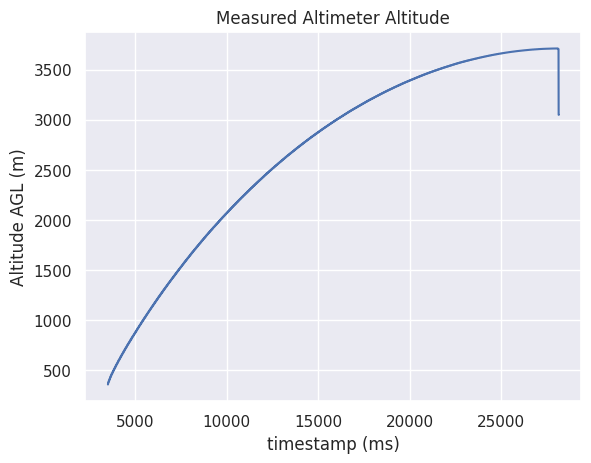

In [24]:
fig = altim.loc[boost_end:first_charge]['alt_m_agl'].plot()
fig.set_ylabel("Altitude AGL (m)")
fig.set_title("Measured Altimeter Altitude")

# Fitting a parabola

In [25]:
nice_data = altim.loc[boost_end:first_charge].copy()
nice_data.index = nice_data.index.to_series() / 1000.0
nice_data.index.set_names("timestamp", inplace=True)

In [26]:
poly = np.polyfit(nice_data.index, nice_data['alt_m_agl'], 2)
print(poly)

def par_fit(x):
    return poly[0] * x * x + poly[1] * x + poly[2]

[  -5.99615313  318.06930795 -543.4317086 ]


In [27]:
xs = np.linspace(boost_end/1000, first_charge/1000, 1000)

In [28]:
ys = par_fit(xs)

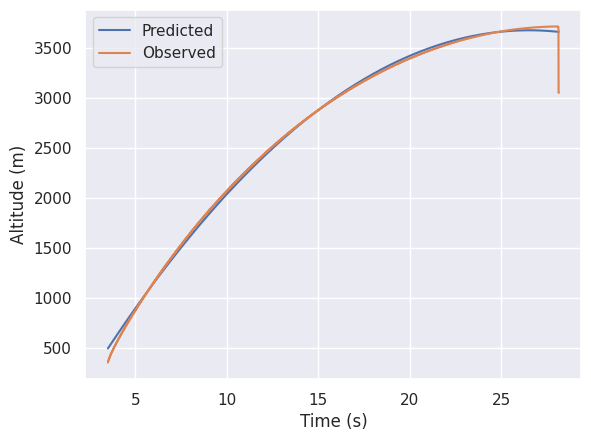

In [29]:
p = sns.lineplot(x=xs, y =ys, label = "Predicted")
p.plot(nice_data['alt_m_agl'], label = "Observed")
p.set_xlabel("Time (s)")
p.set_ylabel("Altitude (m)")
p.legend();

In [30]:
#img%01d.png
def save(in_pattern: str, outfile: str, framerate: int, extra_args: str = ""):
    os.system(f"ffmpeg -framerate {framerate} -i {in_pattern} {extra_args} -y {outfile}")

In [34]:
endpoint_num = 480
endpoints = np.linspace(boost_end/1000+0.01, first_charge/1000, endpoint_num)

In [35]:
apogee_x = nice_data['alt_m_agl'].idxmax()
frame = 0
for end in endpoints:
    data = nice_data.loc[:end]
    all_xs = np.linspace(boost_end/1000, first_charge/1000, 100)

    poly = np.polyfit(data.index, data['alt_m_agl'], 2)
    predictor = np.poly1d(poly)
    prediction = predictor(all_xs)

    plt.figure(figsize=(16,9))

    p = sns.lineplot(x=all_xs, y =prediction, label = "Predicted Altitude", dashes=(1,1), linewidth=3)
    p.plot(data['alt_m_agl'], label = "Observed Altitude", linewidth=3, alpha = 0.75, c='C2')

    p.set_xlim(0, 32)
    p.set_ylim(0, 4000)

    p.set_xlabel("Time (s)")
    p.set_ylabel("Altitude (m)")

    predicted_apogee = all_xs[prediction.argmax()]

    p.axvline(apogee_x, c='C3', label = f"Actual Apogee: {apogee_x:.2f}s", dashes=(2,2))
    p.axvline(predicted_apogee, label = f"Predicted Apogee: {predicted_apogee:.2f}s", c= 'C4', dashes=(2,2))
    
    p.legend(loc="upper left")
    
    plt.savefig(f"intermediate_data/stepped_fitting/{frame:03}.png");
    plt.close()

    frame+=1




In [36]:
save("intermediate_data/stepped_fitting/%03d.png" , "intermediate_data/ParabolaFallingShort.mp4", 60, extra_args = "-vf tpad=stop_mode=clone:stop_duration=2")

ffmpeg version n7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.1.1 (GCC) 20240522
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libdvdnav --enable-libdvdread --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enab

<Axes: xlabel='timestamp (ms)', ylabel='pressure (kPa)'>

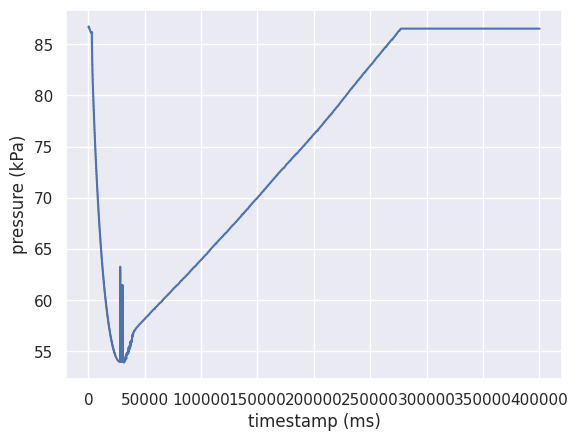

In [33]:
sns.lineplot(df['pressure (kPa)'])
